# Exploring Dandiset 001174: Calcium imaging in SMA and M1 of macaques

This notebook provides an exploration of Dandiset 001174, focusing on calcium imaging data.

**Disclaimer:** This notebook was generated by an AI and has not been fully verified. Please be cautious when interpreting the code or results.

## Dandiset Overview

This Dandiset contains calcium imaging data from the supplementary motor area (SMA) and primary motor area (M1) of rhesus macaques. The study used one-photon calcium imaging with microendoscopes to examine activity patterns of projection neurons. The data were collected while animals were at rest or performing an arm reaching task.

Dandiset URL: https://dandiarchive.org/dandiset/001174/0.250331.2218

## Notebook Contents

This notebook will cover:
- Loading the Dandiset using the DANDI API
- Loading an NWB file from the Dandiset
- Examining the structure and metadata of the NWB file
- Visualizing fluorescence traces for selected ROIs
- Visualizing the spatial footprints of the ROIs

## Required Packages

The following packages assumed to be installed in your environment:
- dandi
- pynwb
- h5py
- remfile
- numpy
- matplotlib
- seaborn

## Loading the Dandiset

We can load the Dandiset and inspect its basic information using the `dandi` Python package.

In [1]:
from itertools import islice
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001174", "0.250331.2218")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

# List some assets in the Dandiset
assets = dandiset.get_assets()
print("\nFirst 5 assets:")
for asset in islice(assets, 5):
    print(f"- {asset.path} (ID: {asset.identifier})")

Dandiset name: Calcium imaging in SMA and M1 of macaques
Dandiset URL: https://dandiarchive.org/dandiset/001174/0.250331.2218

First 5 assets:
- sub-V/sub-V_ses-20230309T110929_ophys.nwb (ID: a2b04c7f-f671-4a55-ac36-5df4d842dfc2)
- sub-Q/sub-Q_ophys.nwb (ID: de07db56-e7f3-4809-9972-755c51598e8d)
- sub-Q/sub-Q_ses-20220922T131747_ophys.nwb (ID: ac161d0e-7642-48bd-9bef-8eff59319d48)
- sub-Q/sub-Q_ses-20221003T131952_ophys.nwb (ID: 9c3678d5-22c3-402c-8cd4-6bc38c4d61e3)
- sub-Q/sub-Q_ses-20221028T121142_ophys.nwb (ID: b4e6bbf7-0564-4628-b8f0-680fd9b8d4ea)


To get the URL for any asset, you can use the asset ID in the following format:
`https://api.dandiarchive.org/api/assets/<ASSET_ID>/download/`

## Loading an NWB File

We will now load one of the NWB files from the Dandiset. For this example, we will use the file located at `sub-Q/sub-Q_ophys.nwb` with the asset ID `de07db56-e7f3-4809-9972-755c51598e8d`.

We will use `pynwb`, `h5py`, and `remfile` to stream the data from the DANDI archive.

In [2]:
import pynwb
import h5py
import remfile

# Hardcoded URL for the selected NWB file
url = "https://api.dandiarchive.org/api/assets/de07db56-e7f3-4809-9972-755c51598e8d/download/"

# Load the NWB file
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

print("NWB file loaded successfully.")

NWB file loaded successfully.


## NWB File Contents and Metadata

Let's explore some of the top-level metadata and contents of this NWB file.

In [3]:
print(f"Session description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject species: {nwb.subject.species}")

Session description: Calcium imaging in SMA during the spontaneous condition
Identifier: 5c2c4bb2-8310-4e0e-ae01-fd872edba928
Session start time: 2022-09-15 13:16:33.129000+00:00
Subject ID: Q
Subject species: Macaca mulatta


The NWB file contains various data streams and metadata organized hierarchically. Key sections include `acquisition` for raw acquired data and `processing` for processed data. This file contains `OnePhotonSeries` in the `acquisition` section and `ophys` (optical physiology) data in the `processing` section, which includes `EventAmplitude`, `Fluorescence`, and `ImageSegmentation`.

A simplified view of the relevant structure for this exploration:

```
NWBFile
└── acquisition
    └── OnePhotonSeries (raw calcium imaging video)
└── processing
    └── ophys
        ├── EventAmplitude (amplitude of neural events)
        ├── Fluorescence (fluorescence traces for ROIs)
        └── ImageSegmentation (spatial footprints of ROIs)
            └── PlaneSegmentation
                └── image_mask (masks for each ROI)
```

## Visualizing Fluorescence Traces

We can extract and visualize the fluorescence traces for individual ROIs. This data is located within `processing/ophys/Fluorescence/RoiResponseSeries`.

Fluorescence data shape: (6041, 40)
Number of ROIs: 40 (IDs: 0 to 39)


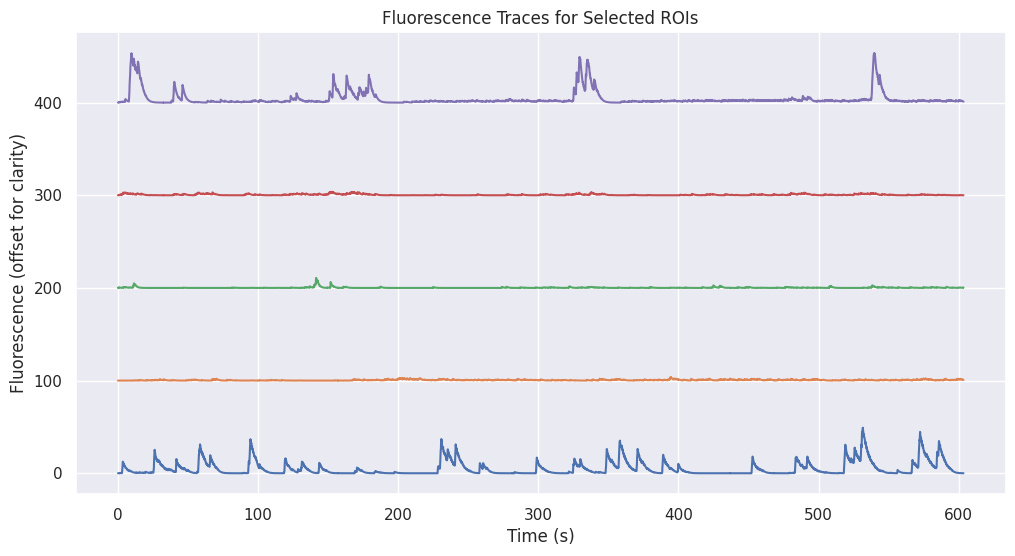

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme() # Use seaborn styling for a better look

# Get Fluorescence data and ROI information
roi_response_series = nwb.processing["ophys"].data_interfaces["Fluorescence"].roi_response_series["RoiResponseSeries"]
fluorescence_data = roi_response_series.data
rate = roi_response_series.rate

# Get ImageMask data and ROI IDs
plane_segmentation = nwb.processing["ophys"].data_interfaces["ImageSegmentation"].plane_segmentations["PlaneSegmentation"]
image_masks = plane_segmentation.image_mask
roi_ids = plane_segmentation.id[:]

# Stack the image masks
num_masks = len(image_masks)
masks_array = np.array([image_masks[i][:] for i in range(num_masks)])

print(f"Fluorescence data shape: {fluorescence_data.shape}")
print(f"Number of ROIs: {num_masks} (IDs: {roi_ids[0]} to {roi_ids[-1]})")

# Plot fluorescence traces for the first 5 ROIs
num_rois_to_plot = 5
time = np.arange(fluorescence_data.shape[0]) / rate

plt.figure(figsize=(12, 6))
for i in range(min(num_rois_to_plot, fluorescence_data.shape[1])):
    plt.plot(time, fluorescence_data[:, i] + i * 100, label=f'ROI {roi_ids[i]}') # Adding offset for clarity and using ROI IDs

plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (offset for clarity)')
plt.title('Fluorescence Traces for Selected ROIs')
# plt.legend() # Legend is not useful with the offsets, use colors to distinguish

plt.show()

The plot above shows the fluorescence intensity over time for the first 5 identified Regions of Interest (ROIs). We can observe transient increases in fluorescence, which are indicative of neural activity. This fluorescence data is typically corrected or 'processed' data, but the specific preprocessing steps are not detailed in this NWB file's metadata.

## Visualizing Image Masks

The `ImageSegmentation` section contains the spatial masks for each identified ROI. We can visualize these masks to see the spatial footprints of the putative neurons.

### Maximum Projection of all Masks

First, let's visualize the maximum projection of all masks to see the overall spatial extent of the imaged ROIs.

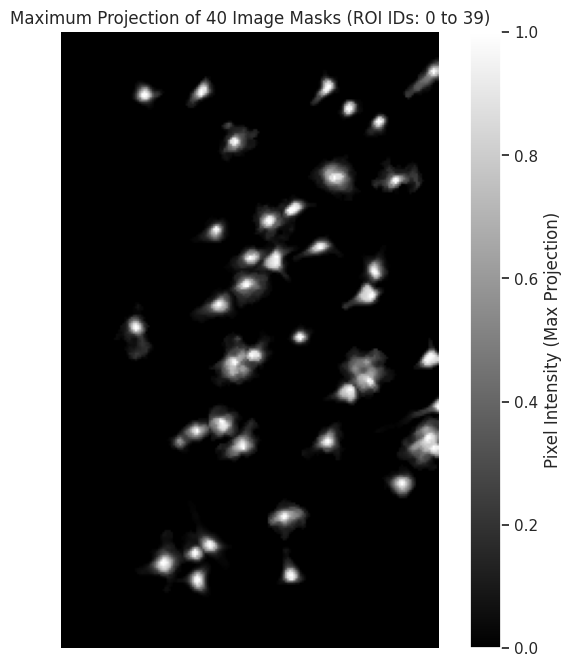

In [5]:
# Create a maximum projection across all masks
max_projection = np.max(masks_array, axis=0)

plt.figure(figsize=(8, 8))
plt.imshow(max_projection, cmap='gray')
plt.title(f'Maximum Projection of {num_masks} Image Masks (ROI IDs: {roi_ids[0]} to {roi_ids[-1]})')
plt.axis('off')
plt.colorbar(label='Pixel Intensity (Max Projection)')

plt.show()

### Individual ROI Masks

Let's also visualize a few individual ROI masks to see their specific shapes.

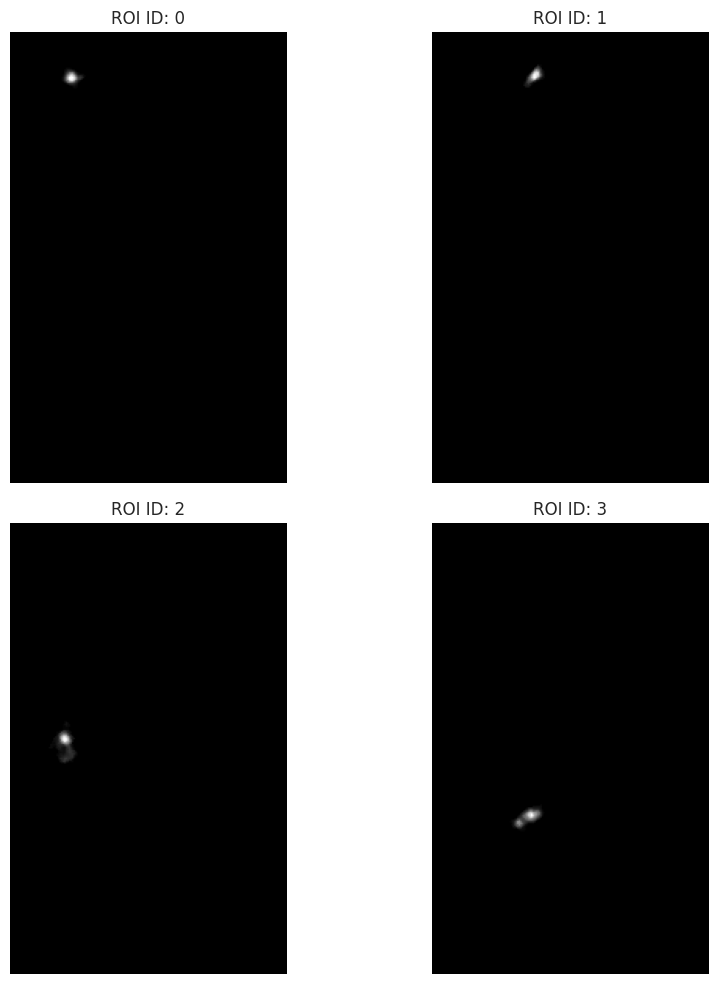

In [6]:
# Visualize a few individual ROI masks (e.g., first 4)
num_individual_masks_to_plot = min(4, num_masks)

plt.figure(figsize=(10, 10))
for i in range(num_individual_masks_to_plot):
    plt.subplot(2, 2, i + 1)
    plt.imshow(masks_array[i, :, :], cmap='gray')
    plt.title(f'ROI ID: {roi_ids[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

The image above shows the maximum projection of the image masks for all identified ROIs, and the plots below visualize individual ROI masks. Each bright area represents the spatial footprint of a detected ROI (putative neuron). These visualizations help understand the location and extent of the imaged neurons in the field of view.

You can also explore this NWB file interactively using Neurosift:
https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/de07db56-e7f3-4809-9972-755c51598e8d/download/&dandisetId=001174&dandisetVersion=draft

## Basic Advanced Analysis: Average Fluorescence Trace

As a simple "advanced" analysis example, let's compute and plot the average fluorescence trace across all ROIs.

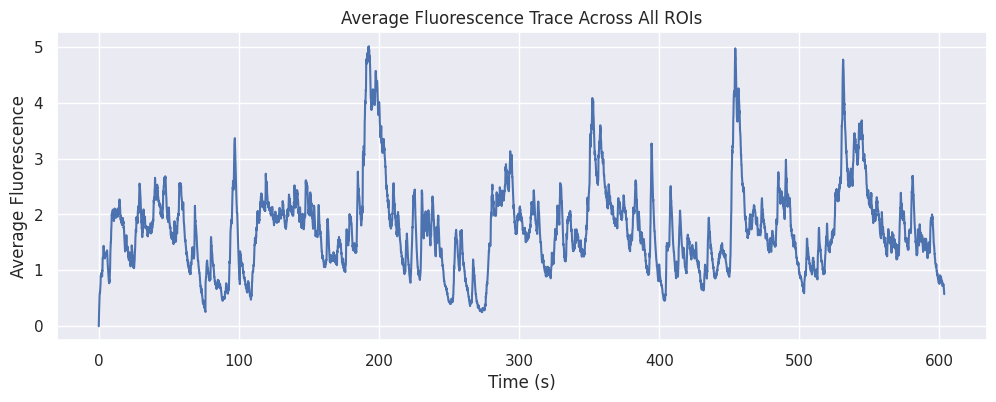

In [7]:
# Calculate the average fluorescence trace
average_fluorescence = np.mean(fluorescence_data[:], axis=1)

plt.figure(figsize=(12, 4))
plt.plot(time, average_fluorescence)
plt.xlabel('Time (s)')
plt.ylabel('Average Fluorescence')
plt.title('Average Fluorescence Trace Across All ROIs')
plt.grid(True)
plt.show()

This plot shows the average fluorescence activity of all recorded ROIs over time. This can sometimes reveal general trends in neural activity across the imaged population.

## Summary and Future Directions